<H1>Import Libraries</H1>

In [1]:
import os
import sys
import time
import copy
import random
import warnings
import pickle
import os
import json
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from collections import Counter

# Plot settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Ignore warnings
warnings.filterwarnings("ignore")

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda:0


# Measures

In [2]:
def accuracy(outp, target):
    """Computes accuracy"""
    with torch.no_grad():
        pred = torch.argmax(outp, dim=1)
        correct = pred.eq(target).float().sum().item()
        return 100.0 * correct / target.size(0)

In [3]:
def Print(string, dictionary):
    first_key = next(iter(dictionary))
    first_value = dictionary[first_key]
    print(f"{string}:{first_key}: {first_value[0][0]}\n")

In [4]:
def forbinus_norm_function(w_i):
    value = 0
    for k in w_i.keys():
        value += torch.linalg.norm(w_i[k])
    return value.item()

In [5]:
def model_deviation_function(w_i, w_f):
    model_deviation = 0
    for k in w_i.keys():
        model_deviation += torch.linalg.norm(w_f[k].to(torch.float) - w_i[k].to(torch.float)) / torch.linalg.norm(w_i[k].to(torch.float))
    #print(model_deviation.item())
    return model_deviation.item()

# Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#====CNN model
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.5)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Adjust input size here
        self.relu5 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)  # Add a linear layer for classification

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(x.size(0), -1)
        x = self.relu5(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        return x


# Train

In [7]:
def train(i_weights, epochs, train_loader, le_rate, cli,roun, epoch_flag, w_l):
    global opti
    local_model = model().to(device)
    criterion = nn.CrossEntropyLoss()
    # u_le_rate=(le_rate * w_l)
    if opti=="adam":
        optimizer = torch.optim.Adam(local_model.parameters(), lr=le_rate)
    elif opti=="sgd":
        optimizer = torch.optim.SGD(local_model.parameters(), lr=le_rate)
    
    epoch_train_accuracy=0 
    epoch_train_loss=0
    epoch_test_accuracy=0
    epoch_test_loss=0
    epoch_rmd=0

    local_model.load_state_dict(i_weights)

    local_model.train()  # Set the model to training mode

    # initial weights cathing and printing
    initial_weights = {k: v.clone() for k, v in local_model.state_dict().items()}
    #Print("Model's inside the function Initial weights for client",initial_weights)

    # Training loop
    for epoch in range(epochs):
        epoch_flag=epoch_flag+1
        # gradients_this_epoch = {}
        total_samples = 0
        total_loss=0
        correct_samples = 0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward + backward + optimize
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(local_model.parameters(), max_norm=1.0)
            total_loss += loss.item()
            optimizer.step()

            _, predicted = outputs.max(1)  # Get the index of the maximum value in outputs (predicted class)
            total_samples += labels.size(0)
            correct_samples += predicted.eq(labels).sum().item()
        
        if(total_samples!=0 and len(train_loader)!=0):
            epoch_accuracy = 100 * correct_samples / total_samples
            epoch_loss = total_loss / len(train_loader)
        else:
            epoch_accuracy = 100 * correct_samples / (total_samples+1)
            epoch_loss = total_loss / (len(train_loader)+1)
        # print(f"Round {roun}, client {cli}, epoch {epoch}: epoch_accuracy {epoch_accuracy}, epoch_loss {epoch_loss} ")
    
    f_weights = {k: v.clone() for k, v in local_model.state_dict().items()}

    print(f"\n Round {roun}, client {cli+1}: epoch_accuracy {epoch_accuracy}, epoch_loss {epoch_loss} \n")
    epoch_train_accuracy=epoch_accuracy
    epoch_train_loss=epoch_loss
    epoch_test_accuracy, epoch_test_loss= test(f_weights, test_loader)
    
    
    epoch_rmd=0#=model_deviation_function(initial_weights,f_weights)
    
    #saving data into dataframe
    epoch_data = [roun, cli, epoch_train_accuracy, epoch_train_loss, epoch_test_accuracy, epoch_test_loss, epoch_rmd]
    epoch_results.loc[len(epoch_results)] = epoch_data
    
    return epoch_accuracy,epoch_loss, f_weights, epoch_flag

# Test

In [8]:
def test(w,data):
    lmodel = model().to(device)
    criterion = nn.CrossEntropyLoss()
    lmodel.load_state_dict(w)
    lmodel.eval()

    # Evaluation phase for test set
    acc_list = []
    loss_list = []

    with torch.no_grad():
        for j, data in enumerate(data, 0):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            out = lmodel(images)
            # Calculate loss
            loss = criterion(out, labels)
            loss_list.append(loss.item())
            #calculate accuracy
            acc = accuracy(out, labels)
            acc_list.append(acc)
    test_loss = np.mean(loss_list)
    test_accuracy = np.mean(acc_list)
    return test_accuracy, test_loss

# FL Structure

In [9]:
def calculate_flri(client_updates, client_weights):
    """
    client_updates: list of model update tensors (delta_w_k), flattened
    client_weights: list of weights (alpha_k), usually n_k / total_n
    """
    assert len(client_updates) == len(client_weights), "Mismatch between updates and weights"

    # Compute the weighted average update
    avg_update = sum(w * u for w, u in zip(client_weights, client_updates))

    def cosine_sim(a, b):
        return torch.nn.functional.cosine_similarity(a, b, dim=0)

    # Compute weighted disagreement
    rosa_t = 0.0
    for w_k, delta_k in zip(client_weights, client_updates):
        sim = cosine_sim(delta_k, avg_update)
        rosa_t += w_k * (1 - sim)
    
    return rosa_t.item()


In [10]:
def flatten_model_update(update_dict):
    """
    Convert a dict of parameter tensors (model state dict differences)
    to one 1D flattened tensor.
    """
    flat_params = []
    for key in update_dict:
        flat_params.append(update_dict[key].flatten())
    return torch.cat(flat_params)


In [11]:
# ---------- Utility Functions ----------
def flatten_weights(state_dict):
    return torch.cat([p.view(-1) for p in state_dict.values()])

def cosine_similarity(a, b):
    dot = torch.sum(a * b)
    return dot / (torch.norm(a) * torch.norm(b) + 1e-12)

In [12]:
def plot_metric_over_rounds(metric_history):
    for metric_name, client_data in metric_history.items():
        plt.figure(figsize=(10, 6))
        for client_id, values in client_data.items():
            plt.plot(values, label=f'Client {client_id}')
        plt.xlabel("Rounds")
        plt.ylabel(metric_name.replace("_", " ").title())
        plt.title(f'{metric_name.replace("_", " ").title()} per Client over Rounds')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [13]:


import torch

def cosine_similarity(u, v):
    """Cosine similarity between two tensors."""
    sim = torch.dot(u, v) / (torch.norm(u) * torch.norm(v) + 1e-8)
    return max(sim.item(), 0.0)  # ReLU behavior

def directional_trust_aggregation(initial_weights, client_weights, client_sizes, client_histories, t, epsilon=1e-6):
    num_clients = len(client_weights)

    # Compute delta_w for each client
    delta_ws = []
    for c_weights in client_weights:
        delta_w = {k: c_weights[k] - initial_weights[k] for k in initial_weights}
        delta_ws.append(delta_w)

    # Flatten delta_w for cosine similarity
    flat_updates = [torch.cat([v.flatten() for v in dw.values()]) for dw in delta_ws]
    peer_sums = [sum(flat_updates[j] for j in range(num_clients) if j != i) for i in range(num_clients)]

    # Compute rho_i
    rho = []
    for i in range(num_clients):
        sim = F.cosine_similarity(flat_updates[i], peer_sums[i], dim=0).item()
        rho.append(max(sim, 0.0))

    # Rolling trust s_i
    s = []
    for i in range(num_clients):
        prev_s = client_histories.get(i, {'s': [1.0]})['s'][-1]
        s_i = ((t - 1) / t) * prev_s + (1 / t) * rho[i]
        s.append(s_i)
        client_histories.setdefault(i, {"s": [], "rho": [], "nu": [], "s_tilde": [], "a": []})
        client_histories[i]["s"].append(s_i)
        client_histories[i]["rho"].append(rho[i])

    # Stability penalty nu_i
    nu = []
    for i in range(num_clients):
        s_prev = client_histories[i]["s"][-2] if len(client_histories[i]["s"]) > 1 else 1.0
        nu_i = abs(s[i] - s_prev) / (s_prev + epsilon)
        nu.append(nu_i)
        client_histories[i]["nu"].append(nu_i)

    # Stability-corrected trust
    s_tilde = [s[i] / (1 + nu[i]) for i in range(num_clients)]
    for i in range(num_clients):
        client_histories[i]["s_tilde"].append(s_tilde[i])

    # Aggregation weights (LaTeX version — no client size weighting)
    total_weight = sum(s_tilde)
    a = [s_tilde[i] / total_weight for i in range(num_clients)]
    for i in range(num_clients):
        client_histories[i]["a"].append(a[i])

    # Aggregate global weights
    aggregated_weights = {
        k: sum(a[i] * (initial_weights[k] + delta_ws[i][k]) for i in range(num_clients))
        for k in initial_weights
    }

    return aggregated_weights, client_histories, a


In [14]:
def federated_learning(i_w, data_client, C, P, R, E, learning_rate, b_size):
    
    global total_clients_list, participating_client_list, val_loader, folder_name, norms_results, client_histories
    
    global_model.load_state_dict(i_w)
    #Print("Model's initial weights", i_w)
    r_flag=0
    weights = [1] * C
    global delta_ad
    global weight_c
    # client_histories = {}
    
    #loop for round
    for r in range(1,R+1):
        round_train_accuracy=0
        round_train_loss=0
        round_test_accuracy=0
        round_test_loss=0
        epoch_flag=0

        #saving initial weights for spiking model
        i_w = {k: v.clone() for k, v in global_model.state_dict().items()}
        #Print("Model's initial weights", i_w)
        
        #colleting weights and results
        all_final_weights={}
        train_accuracy_list=[]
        train_loss_list=[]

        update_list=[]
        weight_list=[]
        client_sizes = []
        
        # Randomly select clients
        selected_clients = random.sample(total_clients_list, P)
        participating_client_list.append(selected_clients)

        #loop for client
        for c, data in enumerate(data_client):
            
            if(c in selected_clients):
                train_loader = torch.utils.data.DataLoader(data, batch_size=b_size, shuffle=True)
                
                train_accuracy, train_loss, c_f_weights, epoch_flag = train(i_w, E, train_loader, learning_rate, c, r, epoch_flag, weights[c])
                
                train_accuracy_list.append(train_accuracy)
                train_loss_list.append(train_loss)

                model_update = {}
                for key in global_model.state_dict():
                    model_update[key] = torch.sub(c_f_weights[key], i_w[key])
                
                update_list.append(model_update)
                weight_list.append(c_f_weights)
                client_sizes.append(len(data_client[c]))

            else:
                print(f"client {c} is not selectecd")
        
        #calcualting AD
        ad_c_list = []
        num_participants = len(update_list)
        for i in range(num_participants):
            dists = []
            for j in range(num_participants):
                if i != j:
                    diff = 0.0
                    for key in update_list[i]:
                        # diff += torch.norm(update_list[i][key] - update_list[j][key], p=2).item() ** 2
                        diff += torch.norm(update_list[i][key].float() - update_list[j][key].float(), p=2).item() ** 2

                    dists.append(diff)
            ad_c = sum(dists) / (num_participants - 1)
            ad_c_list.append(ad_c)
        delta_ad[f"round_{r}"]=(ad_c_list, r)

        #list and round counter
        round_epoch=(epoch_flag)
        
        #print("Total number of selected clients is", client_counter)
        round_train_loss=sum(train_loss_list)/len(train_loss_list)
        round_train_accuracy=sum(train_accuracy_list)/len(train_accuracy_list)

        print(f"\n\n Model's Round: {r}, train accuracy of model: {round_train_accuracy}, train loss of model: {round_train_loss}")

        # FedAvg aggregation
        # all_final_weights = fed_avg(weight_list, client_sizes)
        # all_final_weights, client_histories, trust_weights = directional_trust_aggregation(i_w, weight_list, client_sizes, client_histories, r)
        all_final_weights, client_histories, trust_weights = directional_trust_aggregation(i_w, weight_list, client_sizes, client_histories, r)

        
        # flat_updates = [flatten_model_update(update) for update in update_list]
        # # total_samples = sum(client_sizes)
        # # client_weights = [size / total_samples for size in client_sizes]
        # flri=calculate_flri(flat_updates, trust_weights)
        # print(f"round {r} = flri {flri}")
        
        
        round_test_accuracy, round_test_loss=test(all_final_weights, test_loader)
        print(f"Model's Round: {r}, test accuracy of model: {round_test_accuracy}, test loss of model: {round_test_loss}")
        
        list_accuracy.append(round_train_accuracy)
        list_loss.append(round_train_loss)
        list_test_accuracy.append(round_test_accuracy)
        list_test_loss.append(round_test_loss)
        
        #model deviation code
        # round_rmd=model_deviation_function(i_w, all_final_weights)
        #print("Model deviation values: ", model_deviation)
        
        #saving data into dataframe
        round_data = [round_train_accuracy, round_train_loss, round_test_accuracy, round_test_loss, round_epoch]
        round_results.loc[len(round_results)] = round_data
        
        global_model.load_state_dict(all_final_weights)
        print("round", r, "completed \n\n")

# Main Function

# Define parameters

In [15]:
#===========================Parameters==============================================================
client_no=10
participating_client=10
epochs=5
learning_rate=0.01
round_no=60
batch_size=64
data_class=10

opti="sgd"
# opti="adam"
client_histories = {}

mathod="fed_SCS"

# set_up='IID'
# set_up='non_IID'
set_up='salt_pepper'
# set_up='mislabelled'

# iid
# distribution=f"clients_no_{client_no}_data_IID_CIFAR10_alpha_infinity"

#non_iid
# distribution=f"clients_no_{client_no}_data_IID_CIFAR10_alpha_0.1"
# distribution=f"clients_no_{client_no}_data_IID_CIFAR10_alpha_0.5"

#salt_pepper
# distribution=f"clients_no_5_10_IID_CIFAR10_alpha_infinity_0.6"
# distribution=f"clients_no_5_10_data_non-IID_CIFAR10_alpha_0.1_0.6"
distribution=f"clients_no_5_10_data_non-IID_CIFAR10_alpha_0.5_0.6"


#misslabelled
# distribution=f"IID_clients_1_2_3_4_60pct_mislabeled_CIFAR10_infinity"
# distribution=f"clients_1_2_3_4_60pct_mislabeled_CIFAR10_0.1"
# distribution=f"clients_1_2_3_4_60pct_mislabeled_CIFAR10_0.5"


# metric_history = {
#     'mag_consistency': {},
#     'sim_consistency': {},
#     'contribution_stability': {},
#     'beta_normalized': {}
# }


# trust_score_history = {}

metric_history = {
    # 'mu': {},
    'delta': {},
    # 'mu_tilde': {},
    'delta_tilde': {}
}


trust_score_history = {}
trust_weight_history = {}
# 'mag_consistency', 'sim_consistency', 'contribution_stability', 'beta_normalized', 'alignment_score'

# List of clients
total_clients_list = list(range(0, client_no))
# print(total_clients_list)
participating_client_list=[]

# Define dataframe for round results
round_columns = ['train_accuracy', 'train_loss', 'test_accuracy', 'test_loss', 'epoch']
round_results = pd.DataFrame(columns=round_columns)

# Define dataframe for epoch results
epoch_columns = ['round', 'client', 'train_accuracy', 'train_loss', 'test_accuracy', 'test_loss', 'rmd']
epoch_results = pd.DataFrame(columns=epoch_columns)

ad_client_values_list=[]

list_accuracy=[]
list_loss=[]
list_test_accuracy=[]
list_test_loss=[]


delta_ad={}
weight_c={}

#===================================loading the saved weight list====================================================
global_model = model().to(device)
file_path= "i_w.pth"
# initial_weights = {k: v.clone() for k, v in global_model.state_dict().items()}
# torch.save(initial_weights, file_path)
initial_weights=torch.load(file_path,weights_only=False)
Print("Model's initial weights", initial_weights)

folder_name = f"s_based_{mathod}_{opti}_lr={learning_rate}_R={round_no}_E={epochs}_B={batch_size}_{distribution}_no _csize"

Model's initial weights:conv1.weight: tensor([[ 0.1471,  0.1597, -0.0451],
        [ 0.1768, -0.0422,  0.0388],
        [-0.0937,  0.1130,  0.1697]], device='cuda:0')



# Dataset loader

In [16]:

def print_data_distribution(clients_data):
    """
    Print the distribution of class labels for each client.
    """
    for idx, client in enumerate(clients_data):
        labels = [label for (_, label) in client]
        class_counts = Counter(labels)
        sorted_counts = dict(sorted(class_counts.items()))
        print(f"Client {idx} - Total Samples: {len(labels)} - Class Distribution: {sorted_counts}")


pt_path = os.path.join(f'{set_up}', f'{distribution}.pt')

client_datasets = torch.load(pt_path)

print_data_distribution(client_datasets)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Define test set transformations for CIFAR-10 (no augmentation, just normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean for CIFAR-10
                         (0.2023, 0.1994, 0.2010))  # std for CIFAR-10
])
# Load CIFAR-10 test dataset
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
# Create DataLoader for the test set
test_loader = DataLoader(cifar10_test_dataset, batch_size=32, shuffle=False, num_workers=2)


Client 0 - Total Samples: 5000 - Class Distribution: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}
Client 1 - Total Samples: 5000 - Class Distribution: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}
Client 2 - Total Samples: 5000 - Class Distribution: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}
Client 3 - Total Samples: 5000 - Class Distribution: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}
Client 4 - Total Samples: 5000 - Class Distribution: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}
Client 5 - Total Samples: 5000 - Class Distribution: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}
Client 6 - Total Samples: 5000 - Class Distribution: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}
Client 7 - Total Samples: 5000 - Class Distribution: {0: 500, 

<H1>Round zero</H1>

In [17]:
#train accuracy for clients
round_train_accuracy=0
round_train_loss=0
train_accuracy_list=[]
train_loss_list=[]
for c, data in enumerate(client_datasets):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    train_accuracy, train_loss=test(initial_weights, train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
round_train_accuracy=(sum(train_accuracy_list)/len(train_accuracy_list))
round_train_loss=(sum(train_loss_list)/len(train_loss_list))


list_accuracy.append(round_train_accuracy)
list_loss.append(round_train_loss)

#test accuracy for server
round_test_accuracy=0
round_test_loss=0
test_accuracy,test_loss=test(initial_weights,test_loader)
# val_accuracy,val_loss=test(initial_weights,val_loader)

# print(f"{test_accuracy}, {test_loss}, {val_accuracy}, {val_loss}  ")78.5633286236092	0.580178488856349	29.6924920127795	4.21533526246921	0.211582764983177	50	0.72233384847641

round_test_accuracy=(test_accuracy)
round_test_loss=(test_loss)

round_rmd=0
round_epoch=0

round_data = [round_train_accuracy, round_train_loss, round_test_accuracy, round_test_loss, round_epoch]
round_results.loc[len(round_results)] = round_data

# list_val_accuracy.append(val_accuracy)
# list_val_loss.append(val_loss)
list_test_accuracy.append(test_accuracy)
list_test_loss.append(test_loss)


Print("initial_weights", initial_weights)
print(f' train accuracy: {round_train_accuracy}\n train_loss: {round_train_loss}\n test_accuracy: {round_test_accuracy}\n test_loss: {round_test_loss}')

initial_weights:conv1.weight: tensor([[ 0.1471,  0.1597, -0.0451],
        [ 0.1768, -0.0422,  0.0388],
        [-0.0937,  0.1130,  0.1697]], device='cuda:0')

 train accuracy: 9.994066455696203
 train_loss: 2.302823704405676
 test_accuracy: 10.093849840255592
 test_loss: 2.3028393766750543


<H1>Run FL</H1>

In [18]:
federated_learning(initial_weights, client_datasets, client_no, participating_client, round_no, epochs, learning_rate, batch_size)


 Round 1, client 1: epoch_accuracy 11.7, epoch_loss 2.3019570217856877 


 Round 1, client 2: epoch_accuracy 10.44, epoch_loss 2.3022264830673795 


 Round 1, client 3: epoch_accuracy 10.46, epoch_loss 2.30227188218998 


 Round 1, client 4: epoch_accuracy 10.54, epoch_loss 2.302276858800574 


 Round 1, client 5: epoch_accuracy 10.3, epoch_loss 2.3024281550057326 


 Round 1, client 6: epoch_accuracy 10.74, epoch_loss 2.3020928449268583 


 Round 1, client 7: epoch_accuracy 10.34, epoch_loss 2.3024200367022165 


 Round 1, client 8: epoch_accuracy 9.94, epoch_loss 2.302270125739182 


 Round 1, client 9: epoch_accuracy 10.38, epoch_loss 2.3023875121828876 


 Round 1, client 10: epoch_accuracy 10.64, epoch_loss 2.3019133579881887 



 Model's Round: 1, train accuracy of model: 10.547999999999998, train loss of model: 2.302224427838868
Model's Round: 1, test accuracy of model: 10.053913738019169, test loss of model: 2.3020613056402235
round 1 completed 



 Round 2, client 1: epoch_ac

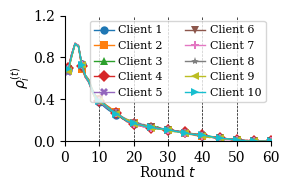

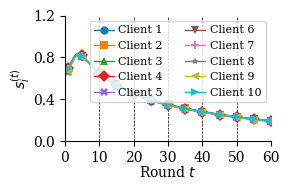

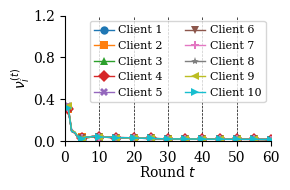

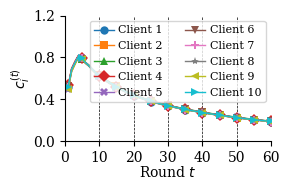

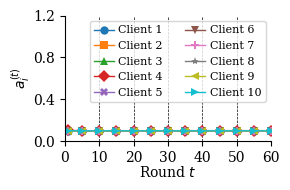

In [39]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

def plot_trust_metrics(client_histories, num_clients=10, num_rounds=60):
    metrics = ['rho', 's', 'nu', 's_tilde', 'a']
    labels = {
        'rho': r'$\rho_i^{(t)}$',
        's': r'$s_i^{(t)}$',
        'nu': r'$\nu_i^{(t)}$',
        's_tilde': r'$c_i^{(t)}$',
        'a': r'$a_i^{(t)}$'
    }

    # Extended markers and colors for 10 clients
    client_markers = ['o', 's', '^', 'D', 'X', 'v', 'P', '*', '<', '>']  # 10 distinct markers
    markevery_interval = 5  # place markers every 5 rounds

    # 10 distinct and readable colors
    client_colors = [
        '#1f77b4',  # blue
        '#ff7f0e',  # orange
        '#2ca02c',  # green
        '#d62728',  # red
        '#9467bd',  # purple
        '#8c564b',  # brown
        '#e377c2',  # pink
        '#7f7f7f',  # gray
        '#bcbd22',  # olive
        '#17becf'   # cyan
    ]

    for metric in metrics:
        plt.figure(figsize=(3, 2))
        lines = []

        for i in range(num_clients):
            values = client_histories[i][metric]

            # Marker alignment for rounds 5, 10, 15, ...
            aligned_markers = [0] + [idx - 1 for idx in range(markevery_interval, len(values) + 1, markevery_interval)]

            color = client_colors[i]
            line, = plt.plot(
                range(1, len(values) + 1),
                values,
                label=f'Client {i+1}',
                marker=client_markers[i],
                markevery=aligned_markers,
                markersize=6,
                linewidth=1,
                linestyle='-',
                color=color,
                markerfacecolor=color,
                markeredgewidth=0
            )
            lines.append(line)

        # Axis labels
        plt.xlabel('Round $t$', fontsize=10, labelpad=0)
        plt.ylabel(labels[metric], fontsize=10, labelpad=0)

        # Ticks and limits
        plt.xticks(range(0, num_rounds + 1, 10), fontsize=10)
        plt.yticks([0, 0.4, 0.8, 1.2], fontsize=10)
        plt.xlim(0, num_rounds)
        plt.ylim(0, 1.2)

        # Legend (smaller for 10 clients)
        plt.legend(handles=lines, fontsize=8, handlelength=1.8, handletextpad=0.4, loc='upper right', ncol=2)

        # Grid and spines
        grid_color = 'black'
        plt.grid(True, axis='x', color=grid_color, linestyle='--', linewidth=0.5)
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color(grid_color)
        ax.spines['bottom'].set_color(grid_color)

        plt.tight_layout()

        # Save
        save_path = f"{metric}_trust_metric.pdf"
        plt.savefig(save_path, dpi=1000, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()

# Example call (assuming you have `client_histories` defined)
plot_trust_metrics(client_histories, num_clients=10, num_rounds=60)


In [28]:
os.makedirs(folder_name, exist_ok=True)

# Save metric_history
with open(os.path.join(folder_name, 'metric_history.pkl'), 'wb') as f:
    pickle.dump(metric_history, f)

# Save trust_score_history
with open(os.path.join(folder_name, 'trust_score_history.pkl'), 'wb') as f:
    pickle.dump(trust_score_history, f)

# Save trust_score_history
with open(os.path.join(folder_name, 'trust_weight_history.pkl'), 'wb') as f:
    pickle.dump(trust_weight_history, f)


In [30]:
# folder_name = f"{mathod}_{opti}_lr={learning_rate}_R={round_no}_ E={epochs}_B={batch_size}_{distribution}"
fn_=f"{mathod}_{opti}_E={epochs}_B={batch_size}_iid"

In [32]:


def plot_train_test_accuracy(round_results, title, folder):
    rounds = list(range(0, len(round_results)))
    train_accuracies = round_results['train_accuracy'].tolist()
    test_accuracies = round_results['test_accuracy'].tolist()

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(rounds, train_accuracies, label='Train Accuracy', color='blue')
    ax.plot(rounds, test_accuracies, label='Test Accuracy', color='green')

    ax.set_xlabel("Round")
    ax.set_ylabel("Server accuracy in %")
    ax.set_title(title)
    ax.set_ylim(0, 100)
    ax.set_xlim(0, len(rounds))
    ax.set_xticks(range(0, len(rounds) + 2, 10))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    os.makedirs(folder, exist_ok=True)
    filename = os.path.join(folder, f"{title}.png")
    plt.savefig(filename, dpi=300)
    plt.show()





def plot_flri(round_results, title, folder):
    rounds = list(range(0, len(round_results)))
    train_accuracies = round_results['flri'].tolist()
    print(train_accuracies)
    # test_accuracies = round_results['test_accuracy'].tolist()

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(rounds, train_accuracies, label='flri', color='blue')
    # ax.plot(rounds, test_accuracies, label='Test Accuracy', color='green')

    ax.set_xlabel("Round")
    ax.set_ylabel("Server accuracy in %")
    ax.set_title(title)
    ax.set_ylim(0, 2)
    ax.set_xlim(0, len(rounds))
    ax.set_xticks(range(0, len(rounds) + 2, 10))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    os.makedirs(folder, exist_ok=True)
    filename = os.path.join(folder, f"{title}.png")
    plt.savefig(filename, dpi=300)
    plt.show()



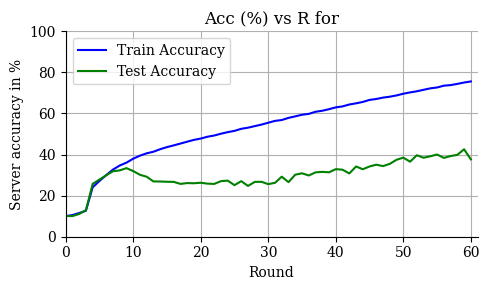

In [33]:
# # title = f"a) AD vs R for {fn_}"
# # plot_rounds_clients_ad(delta_ad, title, folder_name)

title = f"Acc (%) vs R for"
plot_train_test_accuracy(round_results, title, folder_name)

# title = f"flri vs R for {fn_}"
# plot_flri(round_results, title, folder_name)



# Reuslts

In [34]:
save_dir = folder_name  # your desired folder
os.makedirs(save_dir, exist_ok=True)  # create folder if not exists

save_path = os.path.join(save_dir, 'delta_ad_data.pt')
torch.save(delta_ad, save_path)
print(f"[✓] delta_ad saved at {save_path}")

save_path = os.path.join(folder_name, 'delta_ad_data.pt')

# Load the saved file
if os.path.exists(save_path):
    delta_ad_loaded = torch.load(save_path)
    print("[✓] Loaded delta_ad from:", save_path)
    print(delta_ad_loaded)
else:
    print("[✗] File not found at:", save_path)

[✓] delta_ad saved at s_based_fed_SCS_sgd_lr=0.01_R=60_E=5_B=64_clients_no_10_data_IID_CIFAR10_alpha_infinity_no _csize/delta_ad_data.pt
[✓] Loaded delta_ad from: s_based_fed_SCS_sgd_lr=0.01_R=60_E=5_B=64_clients_no_10_data_IID_CIFAR10_alpha_infinity_no _csize/delta_ad_data.pt
{'round_1': ([0.006514057275085774, 0.006227419560135935, 0.0064702965914066116, 0.006479940353570736, 0.0063112878187944685, 0.006476341057047057, 0.006237543929291603, 0.006360824169323164, 0.006613334324500077, 0.006346277770017886], 1), 'round_2': ([0.008390852129877857, 0.008658244481941595, 0.00810998288382955, 0.00856351947770796, 0.007954878683051315, 0.008089390567978028, 0.008391924163872407, 0.008200059091458127, 0.008146562000575288, 0.008105923450890114], 2), 'round_3': ([0.023329701133291032, 0.024798320492354076, 0.022907011069255058, 0.023313245590108486, 0.023208714902529248, 0.025637705913134662, 0.025132545266265897, 0.023068329080445354, 0.023160425558002563, 0.023052586798272115], 3), 'round_

In [35]:
# Round # Define the folder and file name
# folder_name = f"fed_avg_{opti}_{learning_rate}_{name}"  # Folder where the Excel file will be saved
file_name = "round_results.xlsx"

# Check if the folder exists, if not, create it
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# Full path where the Excel file will be saved
file_path = os.path.join(folder_name, file_name)

round_results.to_excel(file_path, index=False)

print("DataFrame successfully written for round results.")

DataFrame successfully written for round results.


In [36]:
# Define the folder and file name
# folder_name =  f"fed_avg_{opti}_{learning_rate}_{name}"   # Folder where the Excel file will be saved
file_name = "epoch_results.xlsx"

# Check if the folder exists, if not, create it
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Full path where the Excel file will be saved
file_path = os.path.join(folder_name, file_name)

epoch_results.to_excel(file_path, index=False)

print("DataFrame successfully written for epoch results.")

DataFrame successfully written for epoch results.
